In [1]:
# Reading EDF files requires the mne module 
import mne
import matplotlib.pyplot as plt
import numpy as np

The documentation of MNE can be found on [this web site](https://mne.tools) and more precisely [to read EDF files](https://mne.tools/dev/generated/mne.io.read_raw_edf.html). You also look at [this tutorial](https://mne.tools/dev/auto_tutorials/clinical/60_sleep.html#sphx-glr-auto-tutorials-clinical-60-sleep-py)


In the first section, the access to raw data is described. For the machine learning experiments, we will use already prepared files: subsampled, segments of 30s, all in numpy arrays. 


# Reading raw data

The dataset can be downloaded from this [link](https://www.physionet.org/content/sleep-edfx/1.0.0/). There is also a useful description on this page. All the data represents more than 8GB in their raw format. 

## Overview of the dataset
It gathers two datasets: Cassette and Telemetry. 

### Sleep Cassette Study and Data

The 153 `SC*` files (SC = Sleep Cassette) were obtained in a 1987-1991 study of age effects on sleep in healthy Caucasians aged 25-101, without any sleep-related medication. Two PSGs of about 20 hours each were recorded during two subsequent day-night periods at the subjects homes. Subjects continued their normal activities but wore a modified Walkman-like cassette-tape.
Files are named in the form `SC4ssNEO-PSG.edf` where `ss` is the subject number, and `N` is the night. 

### Sleep Telemetry Study and Data

The 44 `ST*` files (ST = Sleep Telemetry) were obtained in a 1994 study of temazepam effects on sleep in 22 Caucasian males and females without other medication. Subjects had mild difficulty falling asleep but were otherwise healthy. The PSGs of about 9 hours were recorded in the hospital during two nights, one of which was after temazepam intake, and the other of which was after placebo intake. Files are named in the form `ST7ssNJ0-PSG.edf` where `ss` is the subject number, and `N` is the night.


## Access to some raw files
If you just want to access to some raw files, the `mne` API allows you to fetch some files by providing a list of subjects like this:

In [2]:
"""from mne.datasets.sleep_physionet.age import fetch_data as sleep_casette
from mne.datasets.sleep_physionet.temazepam import fetch_data as sleep_telemetry

files_casette = sleep_casette(subjects=[12], recording=[1])
print(files_casette)
files_telemetry = sleep_telemetry(subjects=[21])
print(files_telemetry)"""

'from mne.datasets.sleep_physionet.age import fetch_data as sleep_casette\nfrom mne.datasets.sleep_physionet.temazepam import fetch_data as sleep_telemetry\n\nfiles_casette = sleep_casette(subjects=[12], recording=[1])\nprint(files_casette)\nfiles_telemetry = sleep_telemetry(subjects=[21])\nprint(files_telemetry)'

In [3]:

# Creation of a function to download the files from the Physionet database

import requests
import os
import string

def download_file(filename, base_url, target_path):
    url = f"{base_url}/{filename}"
    response = requests.head(url)  # Check if the file exists
    if response.status_code == 200:
        full_path = os.path.join(target_path, filename)
        if not os.path.exists(full_path):
            print(f'Downloading from: {url}\nTo: {full_path}')
            with requests.get(url, stream=True) as r:
                r.raise_for_status()
                with open(full_path, 'wb') as f:
                    for chunk in r.iter_content(chunk_size=8192):
                        f.write(chunk)
            print('Download complete.')
        else:
            print('File already exists:', full_path)
        return full_path
    return None

def get_file(type_, subject, recording, base_path):
    config = {
        'sleep-telemetry': ("ST7", ['J'], '01', '24', '1', '2'),
        'sleep-cassette': ("SC4", ['E', 'F', 'G'], '00', '82', '1', '2')
    }

    if type_ not in config:
        raise ValueError('Invalid type')

    prefix, possible_letters, min_subject, max_subject, min_recording, max_recording = config[type_]
    print(f"Subject goes from '{min_subject}' to '{max_subject}' and recording goes from '{min_recording}' to '{max_recording}'")

    path = os.path.join(base_path, type_)
    os.makedirs(path, exist_ok=True)
    
    base_url = f'https://physionet.org/physiobank/database/sleep-edfx/{type_}'
    base_filename = f"{prefix}{subject}{recording}"
    downloaded_files = []

    # Download PSG file
    for letter in possible_letters:
        psg_filename = f"{base_filename}{letter}0-PSG.edf"
        psg_path = download_file(psg_filename, base_url, path)
        if psg_path:
            downloaded_files.append(psg_path)
            # Download corresponding Hypnogram file
            for letter2 in string.ascii_uppercase:
                hyp_filename = f"{base_filename}{letter}{letter2}-Hypnogram.edf"
                hyp_path = download_file(hyp_filename, base_url, path)
                if hyp_path:
                    downloaded_files.append(hyp_path)
                    break
            break

    return downloaded_files

In [4]:
# Example usage:
type_ = 'sleep-cassette'
subject = '00'
recording = '1'
base_path = r'C:\Users\EstebanPapacitoRico\Documents\GitHub\DL_Project\org-data'

filename = get_file(type_, subject, recording, base_path)
print(filename)

Subject goes from '00' to '82' and recording goes from '1' to '2'
File already exists: C:\Users\EstebanPapacitoRico\Documents\GitHub\DL_Project\org-data\sleep-cassette\SC4001E0-PSG.edf
File already exists: C:\Users\EstebanPapacitoRico\Documents\GitHub\DL_Project\org-data\sleep-cassette\SC4001EC-Hypnogram.edf
['C:\\Users\\EstebanPapacitoRico\\Documents\\GitHub\\DL_Project\\org-data\\sleep-cassette\\SC4001E0-PSG.edf', 'C:\\Users\\EstebanPapacitoRico\\Documents\\GitHub\\DL_Project\\org-data\\sleep-cassette\\SC4001EC-Hypnogram.edf']


## Visualization 

Assume you downloaded some raw data files. 

In [5]:
# Look at Telemetry 

data = mne.io.read_raw_edf(filename[0], preload=True)
raw_data = data.get_data()
print("*** type=", type(raw_data), ", taille = ", raw_data.size, ", dims = ", raw_data.shape)
# You can get the metadata included in the file and a list of all channels:
print("*** info :", data.info)
print("*** channels :", data.ch_names)


Extracting EDF parameters from C:\Users\EstebanPapacitoRico\Documents\GitHub\DL_Project\org-data\sleep-cassette\SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...
*** type= <class 'numpy.ndarray'> , taille =  55650000 , dims =  (7, 7950000)
*** info : <Info | 8 non-empty values
 bads: []
 ch_names: EEG Fpz-Cz, EEG Pz-Oz, EOG horizontal, Resp oro-nasal, EMG ...
 chs: 7 EEG
 custom_ref_applied: False
 highpass: 0.5 Hz
 lowpass: 100.0 Hz
 meas_date: 1989-04-24 16:13:00 UTC
 nchan: 7
 projs: []
 sfreq: 100.0 Hz
 subject_info: 4 items (dict)
>
*** channels : ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker']


In [6]:
data.info['sfreq']
print(data.info['sfreq'])
print(len(data.times))

100.0
7950000


Text(0.5, 0, 'temps (h)')

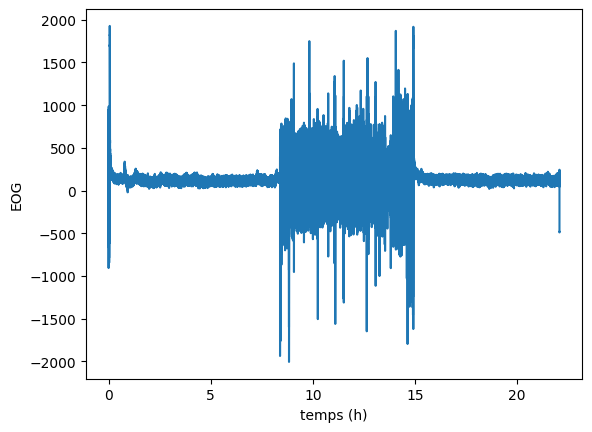

In [7]:
t=data.times
th = t/3600
eog = raw_data[3]
plt.plot(th,eog)
plt.ylabel("EOG")
plt.xlabel("temps (h)")

We can also look at the annotation:

In [8]:
# hypnogramme : on ajoute l'annotation à data

annot = mne.read_annotations(filename[1])
print(type(annot))
data.set_annotations(annot, emit_warning=True)
print(data.annotations[0]) 

for ann in data.annotations[:20]:
    descr = ann["description"]
    start = ann["onset"]
    end = ann["onset"] + ann["duration"]
    print("'{}' goes from {} to {}".format(descr, start, end))

<class 'mne.annotations.Annotations'>
OrderedDict([('onset', 0.0), ('duration', 30630.0), ('description', 'Sleep stage W'), ('orig_time', datetime.datetime(1989, 4, 24, 16, 13, tzinfo=datetime.timezone.utc))])
'Sleep stage W' goes from 0.0 to 30630.0
'Sleep stage 1' goes from 30630.0 to 30750.0
'Sleep stage 2' goes from 30750.0 to 31140.0
'Sleep stage 3' goes from 31140.0 to 31170.0
'Sleep stage 2' goes from 31170.0 to 31200.0
'Sleep stage 3' goes from 31200.0 to 31350.0
'Sleep stage 4' goes from 31350.0 to 31380.0
'Sleep stage 3' goes from 31380.0 to 31440.0
'Sleep stage 4' goes from 31440.0 to 31500.0
'Sleep stage 3' goes from 31500.0 to 31530.0
'Sleep stage 4' goes from 31530.0 to 31650.0
'Sleep stage 3' goes from 31650.0 to 31680.0
'Sleep stage 4' goes from 31680.0 to 31800.0
'Sleep stage W' goes from 31800.0 to 31830.0
'Sleep stage 3' goes from 31830.0 to 31890.0
'Sleep stage 2' goes from 31890.0 to 31950.0
'Sleep stage 3' goes from 31950.0 to 32070.0
'Sleep stage 4' goes from 320

C:\Users\EstebanPapacitoRico\AppData\Local\Temp\ipykernel_33496\3328907108.py:5: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  data.set_annotations(annot, emit_warning=True)


Using matplotlib as 2D backend.


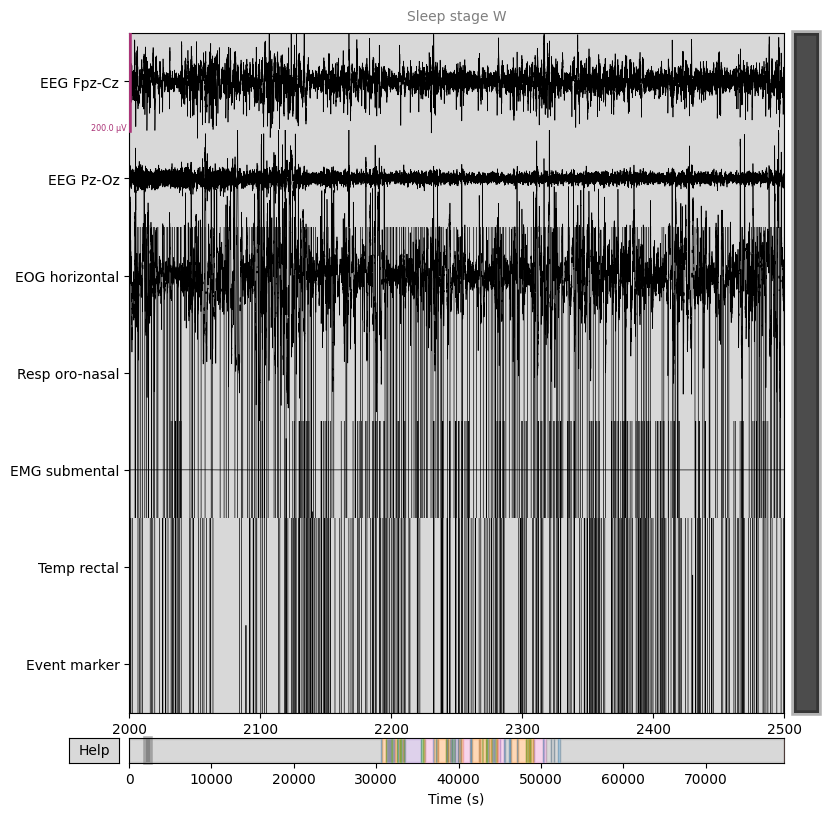

In [9]:
_ = data.plot(
    start=2000,
    duration=500,
    scalings=dict(eeg=1e-4, resp=1e3, eog=1e-4, emg=1e-7, misc=1e-1),
)

Of course we can do the same for the Cassette study, and we can also directly use `matplotlib`. 

Extracting EDF parameters from C:\Users\EstebanPapacitoRico\Documents\GitHub\DL_Project\org-data\sleep-cassette\SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...
*** type= <class 'numpy.ndarray'> , taille =  55650000 , dims =  (7, 7950000)
*** info : <Info | 8 non-empty values
 bads: []
 ch_names: EEG Fpz-Cz, EEG Pz-Oz, EOG horizontal, Resp oro-nasal, EMG ...
 chs: 7 EEG
 custom_ref_applied: False
 highpass: 0.5 Hz
 lowpass: 100.0 Hz
 meas_date: 1989-04-24 16:13:00 UTC
 nchan: 7
 projs: []
 sfreq: 100.0 Hz
 subject_info: 4 items (dict)
>
*** channels : ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker']


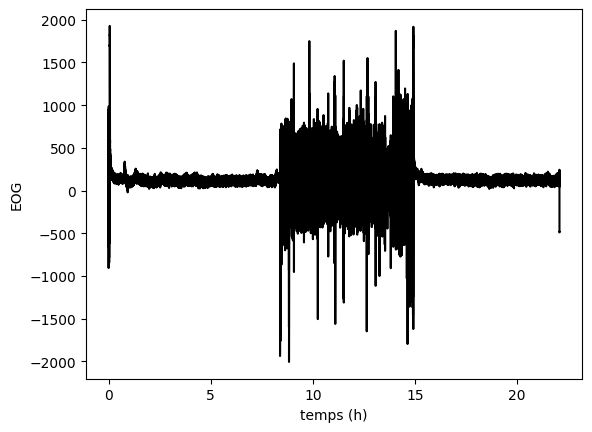

In [10]:
# PSG de cassette *
data = mne.io.read_raw_edf(filename[0], preload=True)
raw_data = data.get_data()
print("*** type=", type(raw_data), ", taille = ", raw_data.size, ", dims = ", raw_data.shape)
# you can get the metadata included in the file and a list of all channels:
print("*** info :", data.info)
print("*** channels :", data.ch_names)
t=data.times
th = t/3600
eog = raw_data[3]
_ = plt.plot(th,eog, 'k',)
_ = plt.ylabel("EOG")
_ = plt.xlabel("temps (h)")

In [11]:
print(data)

<RawEDF | SC4001E0-PSG.edf, 7 x 7950000 (79500.0 s), ~424.6 MB, data loaded>


C:\Users\EstebanPapacitoRico\AppData\Local\Temp\ipykernel_33496\1541574096.py:25: RuntimeWarning: divide by zero encountered in log10
  fourier_transform_db = 20 * np.log10(np.abs((fourier_transform * scalings.get(channel_names[i], 1)/np.max(np.abs(fourier_transform * scalings.get(channel_names[i], 1))))))


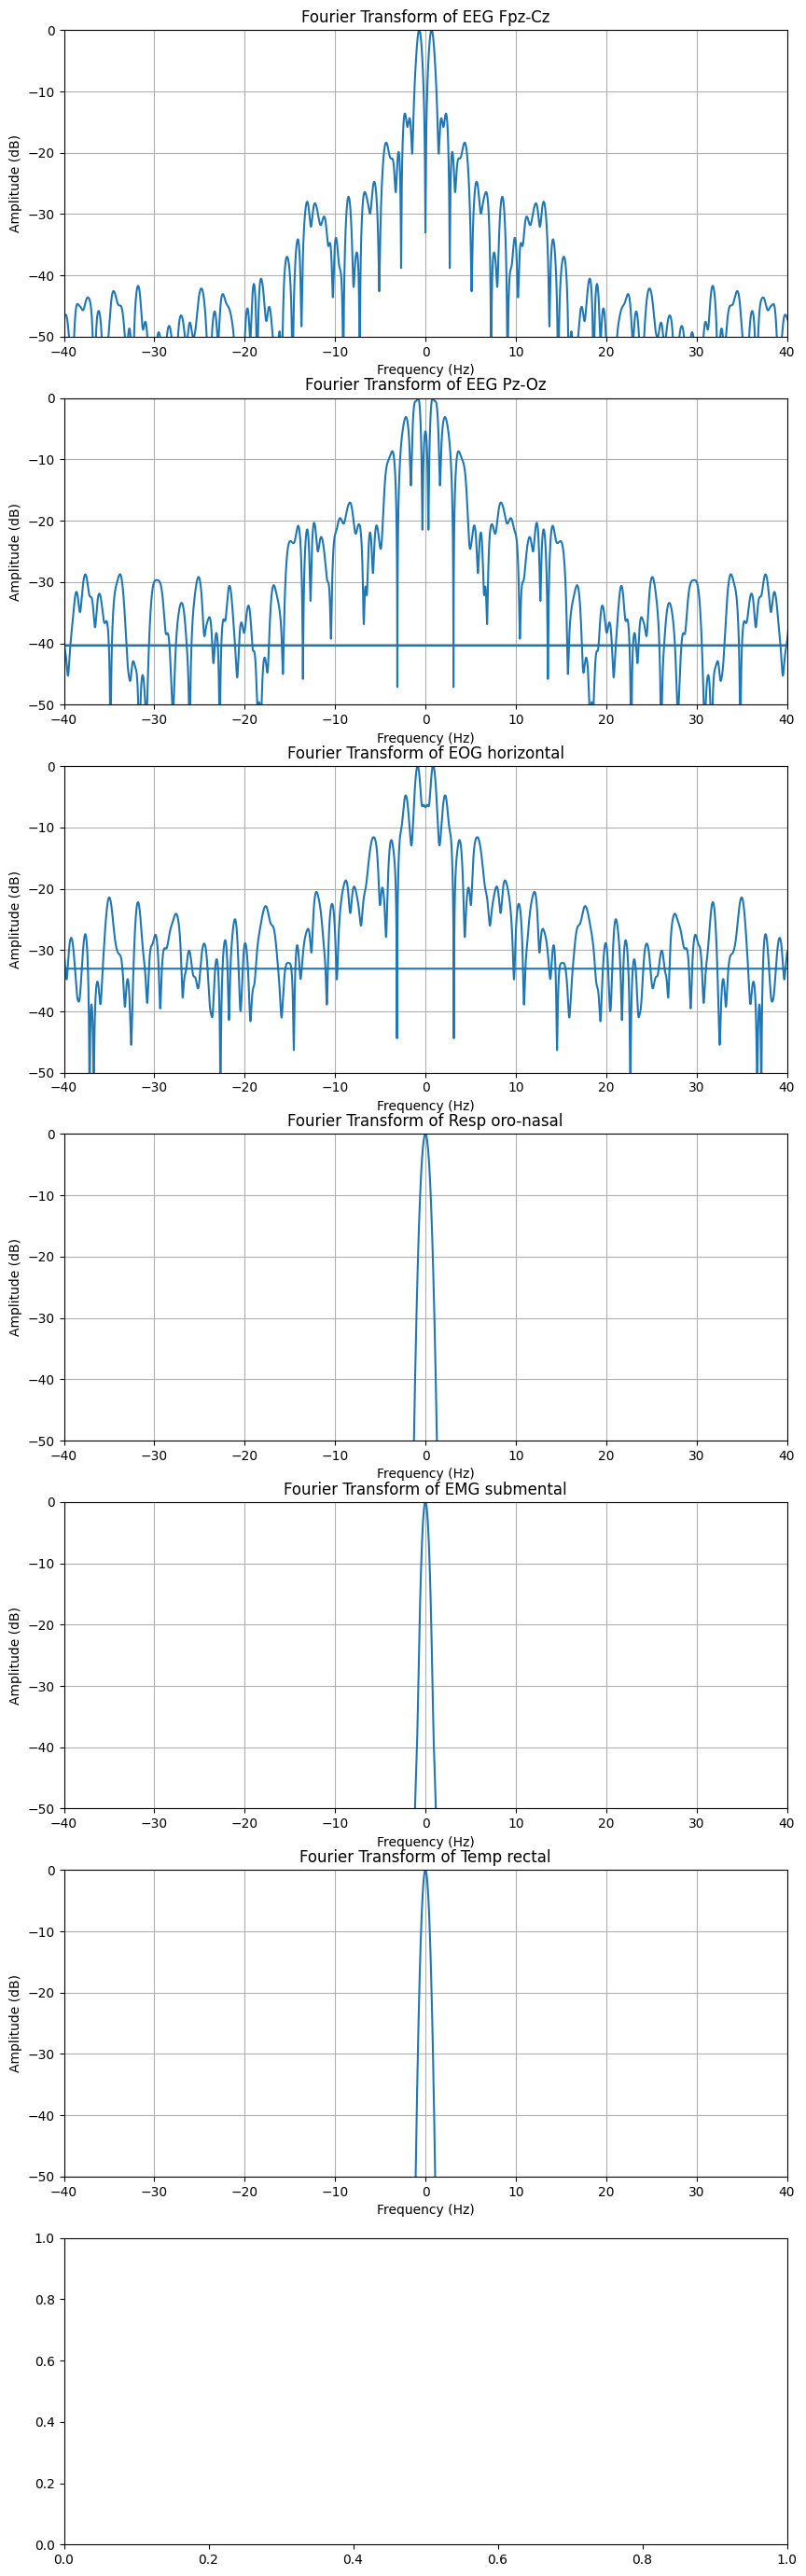

In [12]:
# Get the data and channel names
data_array, times = data[:]
channel_names = data.ch_names

# Get the sampling frequency
sfreq = data.info['sfreq']

# Define the scalings
scalings = dict(eeg=1e-4, resp=1e3, eog=1e-4, emg=1e-7, misc=1e-1)

# Create a grid of subplots
fig, axs = plt.subplots(len(channel_names), 1, figsize=(10, 5*len(channel_names)))

# For each channel
for i in range(data_array.shape[0]-1):
    # Apply Gaussian window
    stddev = 50  # Adjust this value to change the degree of smoothness
    windowed_data = data_array[i] * np.exp(-0.5 * (np.arange(len(data_array[i])) - len(data_array[i])/2)**2 / stddev**2)

    # Compute Fourier Transform
    fourier_transform = np.fft.fft(windowed_data)
    frequencies = np.fft.fftfreq(len(windowed_data), d=1./sfreq)  # Correct the frequencies using the sampling interval

    # Apply scaling and convert to dB
    fourier_transform_db = 20 * np.log10(np.abs((fourier_transform * scalings.get(channel_names[i], 1)/np.max(np.abs(fourier_transform * scalings.get(channel_names[i], 1))))))

    # Plot
    axs[i].plot(frequencies, fourier_transform_db)
    axs[i].set_title(f'Fourier Transform of {channel_names[i]}')
    axs[i].set_xlabel('Frequency (Hz)')
    axs[i].set_ylabel('Amplitude (dB)')
    axs[i].set(xlim=(-40, 40), ylim=(-50, 0))
    axs[i].grid()

In [13]:
from scipy import signal

# Get the original sampling rate
original_sfreq = data.info['sfreq']

# Calculate the new number of samples
new_n_samples = int(len(eog) * 20 / original_sfreq)

# Resample the data
eog_resampled = signal.resample(eog, new_n_samples)

# Calculate the number of samples per segment
samples_per_segment = int(20 * 30)  # 20 kHz * 30 s

# Segment the data
segments = np.array([eog_resampled[i:i+samples_per_segment] for i in range(0, len(eog_resampled), samples_per_segment)])

# Now 'segments' is a 2D array where each row is a 30-second segment of the resampled data

In [18]:
print(len(segments)%600)



250
